<a href="https://colab.research.google.com/github/JanTJung/nlp_projects/blob/main/Intent_slot_identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementation of NLU component of a chatbot

In this assignment I built an application that performs __intent classification__ and __slot filling__, which are the core tasks that take care the **NLU module** in any chatbot. 

*   __intent classification__ consist in mapping user utterance (typically a 
customer) into a predefined set of _intents_ (goals of the user) so the computer can know what she is asking.

* __slot filling__ consist in extracting filler values from the uterance of the user. 


We will use the [ATIS (Airline Travel Information Systems) dataset](https://www.aclweb.org/anthology/H90-1021.pdf), which is  a dataset consisting of audio recordings and corresponding manual transcripts about humans asking for flight information on automated airline travel inquiry systems. The data consists of 17 unique intent categories, and 81 slots in total. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

import spacy
import collections

from spacy import displacy
from collections import Counter
from keras.models import model_from_json
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix



## Data preparation

The data is distributed in three files for train, development and testing. Each have a sentence, which represents the user input (the question), following the label for each word in the sentence and the intent, which represents the intention of the question.

The labels for the words are about important information, like the airport name, the flight time etc. Words without a influence are labeled with a 0.

The distribution of training, development and test sentences is as follows:

- Training set: 4978
- Development set: 500
- Test set: 893

In the further code some example sentences, related labels and intents are printed out. Furthermore the distribution over all intents is printed. With that you can see that there most of the intents are "atis_flight" with over 75% of the intents.

To see the distribution better, the train intents are plotted in their distribution. (Just the train data, as the other ones have similar distribution)

Note: I didn't know what you mean by class distribution. I hope the analysis of the data I provided is sufficient.
- Class distribution for intent classification
- Class distribution for slot filling task. 

In [ ]:
# helper function to read dev and test data format (use get_data2 for training)
def get_data(filename):
    df = pd.read_csv(filename, delim_whitespace=True, names=['word', 'label'])
    beg_indices = list(df[df['word'] == 'BOS'].index)+[df.shape[0]]
    sents, labels, intents = [], [], []
    for i in range(len(beg_indices[:-1])):
        sents.append(df[beg_indices[i]+1:beg_indices[i+1]-1]['word'].values)
        labels.append(df[beg_indices[i]+1:beg_indices[i+1]-1]['label'].values)
        intents.append(df.loc[beg_indices[i+1]-1]['label'])    
    return sents, labels, intents

# helper function to read training data format
def get_data2(filename):
    with open(filename) as f:
        contents = f.read()
    sents, labels, intents = [],[],[]
    for line in contents.strip().split('\n'):
        words, labs = [i.split(' ') for i in line.split('\t')]
        sents.append(words[1:-1])
        labels.append(labs[1:-1])
        intents.append(labs[-1])
    return sents, labels, intents

In [ ]:
data_dir="drive/My Drive/Colab Notebooks/nlp-app-II/data/atis" 
train_file= data_dir + '/atis.train.w-intent.iob'
dev_file= data_dir + '/atis-2.dev.w-intent.iob'
test_file= data_dir + '/atis.test.w-intent.iob'

train_texts, train_slots, train_intents = get_data2(train_file)
dev_texts, dev_slots, dev_intents = get_data(dev_file)
test_texts, test_slots, test_intents = get_data(test_file)

In [ ]:
# Analysis of train
print("Train text: " + str(train_texts[1]))
print("Train labels: " + str(train_slots[1]))
print("Train intents: " + str(train_intents[1]))
print()

#Analysis of dev
print("Development text: " + str(dev_texts[1]))
print("Development labels: " + str(dev_slots[1]))
print("Development intents: " + str(dev_intents[1]))
print()

#Analysis of test
print("Test text: " + str(test_texts[0]))
print("Test labels: " + str(test_slots[0]))
print("Test intents: " + str(test_intents[0]))
print()

print("Total number of:")
print("Training set: " + str(len(train_texts)))
print("Dev set: " + str(len(dev_texts)))
print("Test set: " + str(len(test_texts)))
print()

a_counter_train = collections.Counter(train_intents)
most_common_train = a_counter_train.most_common(5)
print("Distribution of intents in train set: "+ str(most_common_train))

a_counter_dev = collections.Counter(dev_intents)
most_common_dev = a_counter_dev.most_common(5)
print("Distribution of intents in development set: "+ str(most_common_dev))

a_counter_test = collections.Counter(test_intents)
most_common_test = a_counter_test.most_common(5)
print("Distribution of intents in test set: "+ str(most_common_test))

Train text: ['what', 'flights', 'are', 'available', 'from', 'pittsburgh', 'to', 'baltimore', 'on', 'thursday', 'morning']
Train labels: ['O', 'O', 'O', 'O', 'O', 'B-fromloc.city_name', 'O', 'B-toloc.city_name', 'O', 'B-depart_date.day_name', 'B-depart_time.period_of_day']
Train intents: atis_flight

Development text: ['show' 'me' 'all' 'round' 'trip' 'flights' 'between' 'houston' 'and'
 'las' 'vegas']
Development labels: ['O' 'O' 'O' 'B-round_trip' 'I-round_trip' 'O' 'O' 'B-fromloc.city_name'
 'O' 'B-toloc.city_name' 'I-toloc.city_name']
Development intents: atis_flight

Test text: ['i' 'would' 'like' 'to' 'find' 'a' 'flight' 'from' 'charlotte' 'to' 'las'
 'vegas' 'that' 'makes' 'a' 'stop' 'in' 'st.' 'louis']
Test labels: ['O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'B-fromloc.city_name' 'O'
 'B-toloc.city_name' 'I-toloc.city_name' 'O' 'O' 'O' 'O' 'O'
 'B-stoploc.city_name' 'I-stoploc.city_name']
Test intents: atis_flight

Total number of:
Training set: 4978
Dev set: 500
Test set: 893

Distributio

['atis_flight', 'atis_airfare', 'atis_ground_service', 'atis_airline', 'atis_abbreviation', 'atis_aircraft', 'atis_flight_time', 'atis_quantity', 'atis_flight#atis_airfare', 'atis_airport']
[3666, 423, 255, 157, 147, 81, 54, 51, 21, 20]


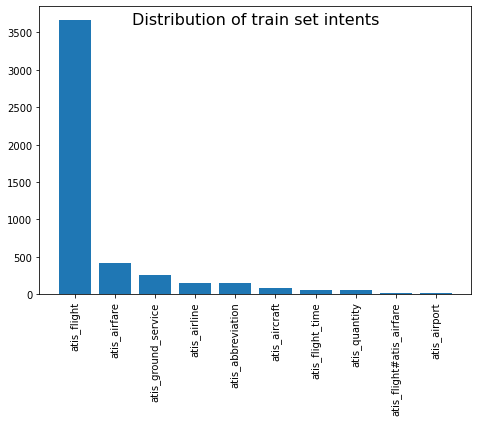

In [ ]:
intents_counter = a_counter_train.most_common(10)
intent_label_train = []
intent_number_train = []
for x in intents_counter:
  intent_label_train.append(x[0])
  intent_number_train.append(x[1])

print(intent_label_train)
print(intent_number_train)
fig = plt.figure()
fig.suptitle('Distribution of train set intents', fontsize=16)
ax = fig.add_axes([0,0,1,1])
ax.bar(intent_label_train, intent_number_train)
ax.tick_params(axis='x', labelrotation=90)
plt.show()

## Preprocess
Data for NLP has to be preprocessed. However, the dataset which was provided already had most of the preprocessing already done. Tokenization and lowering the words, as well as the removal of stop words has already been done. 
I tested applying Lemmatization and Stemming, however these methods also cut significant parts of the labeled words (e.g. Las Vegas became La Vega). As unlabeled words had no influence anyways, i decided to not further preprocess the data. In case the results are not sufficient I would have come back to this part.


In [ ]:
train_set = []
dev_set = []

for x in range(len(train_texts)):
    element = [train_texts[x],train_slots[x]]
    train_set.append(element)

for x in range(len(dev_texts)):
    element = [dev_texts[x],dev_slots[x]]
    dev_set.append(element)


print("Tokenized text: {}".format(train_set[104][0]))
print("Tokens labels: {}".format(train_set[104][1]))
print("Tokens intents: {}".format(train_intents[104]))

print("Network input for label training: {}".format(train_set[104]))


Tokenized text: ['what', 'city', 'is', 'the', 'airport', 'mco', 'in']
Tokens labels: ['O', 'O', 'O', 'O', 'O', 'B-fromloc.airport_code', 'O']
Tokens intents: atis_city
Network input for label training: [['what', 'city', 'is', 'the', 'airport', 'mco', 'in'], ['O', 'O', 'O', 'O', 'O', 'B-fromloc.airport_code', 'O']]


## Build your models

For builiding the models the approach from the labs has been reused. By adapting the data to the LSTM Network no problems with labeling the words occured for the sequence labeling task. 

Also for the intent classification a LSTM has been used by just adaption the data to the network.

Results of the network are analysed further down in the code.

Note: Please note that the code might look a bit strange with several functions dividing the data preparation and model training parts. I know that this is not necessary for a notebook, but as I had big issues with networks error in colab, therefore I run the code on my laptop and afterwards pasted it in here. (Still works)



In [ ]:
def prepare_data_labels():

    train_set = []
    dev_set = []

    for x in range(len(train_texts)):
        element = [train_texts[x],train_slots[x]]
        train_set.append(element)

    for x in range(len(dev_texts)):
        element = [dev_texts[x],dev_slots[x]]
        dev_set.append(element)


    print("Tokenized text: {}".format(train_set[104][0]))
    print("Tokens labels: {}".format(train_set[104][1]))


    train_sentences = [" ".join(sent[0]) for sent in train_set]
    dev_sentences = [" ".join(sent[0]) for sent in dev_set]

    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='',lower=False, oov_token='<OOV>')
    tokenizer.fit_on_texts(train_sentences)

    ## text to word indices
    train_sequences = tokenizer.texts_to_sequences(train_sentences)
    dev_sequences = tokenizer.texts_to_sequences(dev_sentences)

    ## padding
    train_data_labels = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=40)
    dev_data_labels = tf.keras.preprocessing.sequence.pad_sequences(dev_sequences, maxlen=40)


    # process labels
    labels = set([label for sent in train_set for label in sent[1]])
    label2index = {name: i for i, name in enumerate(sorted(labels))}
    index2label = {label2index[name]:name for name in label2index}
    train_labels = []
    for sent in train_set:
        train_labels.append([label2index[label] for label in sent[1]])
    train_labels = tf.keras.preprocessing.sequence.pad_sequences(train_labels, maxlen=40)

    dev_labels = []
    for sent in dev_set:
        dev_labels.append([label2index[label] for label in sent[1]])
    dev_labels = tf.keras.preprocessing.sequence.pad_sequences(dev_labels, maxlen=40)

    # one-hot encoding
    train_labels = tf.keras.utils.to_categorical(train_labels)
    dev_labels = tf.keras.utils.to_categorical(dev_labels)

    return train_data_labels, train_labels, dev_data_labels, dev_labels, labels, tokenizer, index2label, label2index


In [ ]:
def prepare_data_intents():
    global train_intents
    global dev_intents
    train_set = []
    dev_set = []

    for x in range(len(train_texts)):
        element = [train_texts[x], train_intents[x]]
        train_set.append(element)

    for x in range(len(dev_texts)):
        element = [dev_texts[x],dev_intents[x]]
        dev_set.append(element)


    print("Tokenized text: {}".format(train_set[104][0]))
    print("Tokenized intent: {}".format(train_set[104][1]))
    #print("Tokens intents: {}".format(train_intents[104]))


    train_sentences = [" ".join(sent[0]) for sent in train_set]
    dev_sentences = [" ".join(sent[0]) for sent in dev_set]

    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='',lower=False, oov_token='<OOV>')
    tokenizer.fit_on_texts(train_sentences)

    ## text to word indices
    train_sequences = tokenizer.texts_to_sequences(train_sentences)
    dev_sequences = tokenizer.texts_to_sequences(dev_sentences)

    ## padding
    train_data_intents = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=40)
    dev_data_intents = tf.keras.preprocessing.sequence.pad_sequences(dev_sequences, maxlen=40)


    # process intents
    intents = set()
    for sent in train_set:
        intents.add(sent[1])
    #intents = set([intent for sent in train_set for intent in sent[1]])
    intent2index = {name: i for i, name in enumerate(sorted(intents))}
    index2intent = {intent2index[name]:name for name in intent2index}
    train_intents = []
    for sent in train_set:
        train_intents.append([intent2index[sent[1]]])

    train_intents = tf.keras.preprocessing.sequence.pad_sequences(train_intents, maxlen=40)

    dev_intents = []
    for sent in dev_set:
        dev_intents.append([intent2index[sent[1]]])
    dev_intents = tf.keras.preprocessing.sequence.pad_sequences(dev_intents, maxlen=40)

    # one-hot encoding
    train_intents = tf.keras.utils.to_categorical(train_intents)
    dev_intents = tf.keras.utils.to_categorical(dev_intents)

    return train_data_intents, train_intents, dev_data_intents, dev_intents, intents, tokenizer, index2intent, intent2index


In [ ]:
def train_label_model(train_data_labels, train_labels, dev_data_labels, dev_labels, labels, tokenizer):
    
    learning_rate = 0.01
    epochs = 5
    num_classes = len(labels)
    batch_size = 128
    optimizer = 'adam'
    seed = 42
    vocab_size = len(tokenizer.index_word)+1
    emb_size = 300
    lstm_size = 128
    dropout = 0.2

    # model
    model = tf.keras.models.Sequential([
                tf.keras.layers.Input(shape=(None,), dtype='int32', name='word_ids'),
                tf.keras.layers.Embedding(vocab_size, emb_size,
                                          mask_zero=True, trainable=True),
                tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=lstm_size,
                                                                   return_sequences=True)),
                tf.keras.layers.Dropout(dropout),
                tf.keras.layers.Dense(num_classes, activation='softmax')
               ])

    # compile model with ADAM optimizer
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate, ),
                  loss= "categorical_crossentropy",
                  metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

    model.fit(train_data_labels, train_labels,
          batch_size=batch_size, epochs=epochs,
          validation_data=(dev_data_labels, dev_labels) , callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)])

    return model

In [ ]:
def train_intents_model(train_data_intents, train_intents, dev_data_intents, dev_intents, intents, tokenizer):
    
    learning_rate = 0.01
    epochs = 5
    num_classes = len(intents)
    batch_size = 128
    optimizer = 'adam'
    seed = 42
    vocab_size = len(tokenizer.index_word) + 1
    emb_size = 300
    lstm_size = 128
    dropout = 0.2

    # model
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(None,), dtype='int32', name='word_ids'),
        tf.keras.layers.Embedding(vocab_size, emb_size,
                                  mask_zero=True, trainable=True),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=lstm_size,
                                                           return_sequences=True)),
        tf.keras.layers.Dropout(dropout),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    # compile model with ADAM optimizer
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate, ),
                  loss="categorical_crossentropy",
                  metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

    model.fit(train_data_intents, train_intents,
              batch_size=batch_size, epochs=epochs,
              validation_data=(dev_data_intents, dev_intents), callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)])

    return model

In [ ]:
def make_predictions(x_test, y_test, model):
    preds = model.predict(x_test)
    preds = np.argmax(preds, axis=-1)
    labs = np.argmax(y_test, axis=-1)
    preds = [y[x != 0] for x, y in zip(x_test, preds)]
    labs = [y[x != 0] for x, y in zip(x_test, labs)]
    return preds, labs

In [ ]:
train_data_labels, train_labels, dev_data_labels, dev_labels, labels, tokenizer_label, index2label, label2index = prepare_data_labels()
train_data_intents, train_intents, dev_data_intents, dev_intents, intents, tokenizer_intent, index2intent, intent2index = prepare_data_intents()

Tokenized text: ['what', 'city', 'is', 'the', 'airport', 'mco', 'in']
Tokens labels: ['O', 'O', 'O', 'O', 'O', 'B-fromloc.airport_code', 'O']
Tokenized text: ['what', 'city', 'is', 'the', 'airport', 'mco', 'in']
Tokenized intent: atis_city


In [ ]:
#Train the models
label_model = train_label_model(train_data_labels, train_labels, dev_data_labels, dev_labels, labels, tokenizer_label)
intents_model = train_intents_model(train_data_intents, train_intents, dev_data_intents, dev_intents, intents, tokenizer_intent)

Epoch 1/5
39/39 [==============================] - 35s 649ms/step - loss: 0.3870 - accuracy: 0.7283 - recall: 0.6131 - precision: 0.9046 - val_loss: 0.1442 - val_accuracy: 0.8962 - val_recall: 0.8311 - val_precision: 0.9808
Epoch 2/5
39/39 [==============================] - 23s 592ms/step - loss: 0.0695 - accuracy: 0.9443 - recall: 0.9188 - precision: 0.9789 - val_loss: 0.0399 - val_accuracy: 0.9641 - val_recall: 0.9535 - val_precision: 0.9761
Epoch 3/5
39/39 [==============================] - 21s 547ms/step - loss: 0.0252 - accuracy: 0.9790 - recall: 0.9731 - precision: 0.9850 - val_loss: 0.0195 - val_accuracy: 0.9818 - val_recall: 0.9776 - val_precision: 0.9878
Epoch 4/5
39/39 [==============================] - 21s 548ms/step - loss: 0.0150 - accuracy: 0.9872 - recall: 0.9841 - precision: 0.9905 - val_loss: 0.0092 - val_accuracy: 0.9916 - val_recall: 0.9893 - val_precision: 0.9940
Epoch 5/5
39/39 [==============================] - 21s 546ms/step - loss: 0.0097 - accuracy: 0.9913 - re

In [ ]:
#Save model to file, so we dont have to compute it all the time again
"""
model_json = label_model.to_json()
with open("model_1.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
label_model.save_weights("label_model.h5")
print("Saved model to disk")

model_json = intents_model.to_json()
with open("model_2.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
intents_model.save_weights("intents_model.h5")
print("Saved model to disk")"""

Saved model to disk
Saved model to disk


In [ ]:
#Load the previously trained model
"""
json_file = open('model_2.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
intents_model = model_from_json(loaded_model_json)
# load weights into new model
intents_model.load_weights("intents_model.h5")
print("Loaded model from disk")


json_file = open('model_1.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
label_model = model_from_json(loaded_model_json)
# load weights into new model
label_model.load_weights("label_model.h5")
print("Loaded model from disk")"""

# Analysis

As the models are now trained, we can analyse our models now.
For that we have to first bring the test data into a shape with which our network works. With the on the training set created vocabulary, the test sentences are translated into numerical shape, which is then put into the model for a prediction. The prediction is applied to the whole test set, following we will look at some examples that worked well, some didn't. Additionally some plots e.g. the confusing matrix for the intents is shown.

In [ ]:
test_sentences = []
for x in range(len(test_texts)):
    test_sentences.append([" ".join(test_texts[x])])

for x in range(len(test_sentences)):
    test_sentences[x] = test_sentences[x][0]
test_sequences = tokenizer_label.texts_to_sequences(test_sentences)
test_data_labels = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=40)

test_labels = []
for x in range(len(test_slots)):
    short_list = []
    for word in (test_slots[x]).tolist():
        try:
            short_list.append(label2index[word])
        except KeyError:
            short_list.append(label2index['O'])
    test_labels.append(short_list)
test_labels = tf.keras.preprocessing.sequence.pad_sequences(test_labels, maxlen=40)
test_labels = tf.keras.utils.to_categorical(test_labels)


predictions, ground_truth = make_predictions(test_data_labels, test_labels, label_model)


trues_test = [[index2label[i] for i in sentence] for sentence in ground_truth]
preds_test = [[index2label[i] for i in sentence] for sentence in predictions]


The following example shows a perfect prediciton for the slot filling task. All labels are perfectly recognized. The majority of the labels are recognized perfectly. I didn't know a good metric for meassuring the correctness of slot filling tasks, but looking at the data manually, the accuracy is very high. Also the network gives out very good values during training.
Note: In case you give feedback I would be interested in a way to anaylse slot filling. Simple comparing the labeled sentences didn't make sense for me, because just one wrong value doesnt mean the prediction is totally wrong.

In [ ]:
print("Sentence:     " + str(test_sentences[1]))
print("Ground truth: " + str(trues_test[1]))
print("Prediction:   " + str(preds_test[1]))

Sentence:     on april first i need a ticket from tacoma to san jose departing before 7 am
Ground truth: ['O', 'B-depart_date.month_name', 'B-depart_date.day_number', 'O', 'O', 'O', 'O', 'O', 'B-fromloc.city_name', 'O', 'B-toloc.city_name', 'I-toloc.city_name', 'O', 'B-depart_time.time_relative', 'B-depart_time.time', 'I-depart_time.time']
Prediction:   ['O', 'B-depart_date.month_name', 'B-depart_date.day_number', 'O', 'O', 'O', 'O', 'O', 'B-fromloc.city_name', 'O', 'B-toloc.city_name', 'I-toloc.city_name', 'O', 'B-depart_time.time_relative', 'B-depart_time.time', 'I-depart_time.time']


In [ ]:
for x in range(10): #
  print(x)
  print("Ground truth: " + str(trues_test[x]))
  print("Prediction:   " + str(preds_test[x]))

0
Ground truth: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-fromloc.city_name', 'O', 'B-toloc.city_name', 'I-toloc.city_name', 'O', 'O', 'O', 'O', 'O', 'B-stoploc.city_name', 'I-stoploc.city_name']
Prediction:   ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-fromloc.city_name', 'O', 'B-toloc.city_name', 'I-toloc.city_name', 'O', 'O', 'O', 'O', 'O', 'B-stoploc.city_name', 'I-stoploc.city_name']
1
Ground truth: ['O', 'B-depart_date.month_name', 'B-depart_date.day_number', 'O', 'O', 'O', 'O', 'O', 'B-fromloc.city_name', 'O', 'B-toloc.city_name', 'I-toloc.city_name', 'O', 'B-depart_time.time_relative', 'B-depart_time.time', 'I-depart_time.time']
Prediction:   ['O', 'B-depart_date.month_name', 'B-depart_date.day_number', 'O', 'O', 'O', 'O', 'O', 'B-fromloc.city_name', 'O', 'B-toloc.city_name', 'I-toloc.city_name', 'O', 'B-depart_time.time_relative', 'B-depart_time.time', 'I-depart_time.time']
2
Ground truth: ['O', 'B-depart_date.month_name', 'B-depart_date.day_number', 'O', 'O', 'O', 'O', 'O',

Following some labeling that failed:

1st: Tacoma Airport is not correctly identified, but its also hard, as airport sometimes is often labeled with a 0 in the train data.

In [ ]:
print("Sentence:     " + str(test_sentences[32]))
print("Ground truth: " + str(trues_test[32]))
print("Prediction:   " + str(preds_test[32]))

Sentence:     does tacoma airport offer transportation from the airport to the downtown area
Ground truth: ['O', 'B-airport_name', 'I-airport_name', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Prediction:   ['O', 'B-airport_name', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


2nd: Two flight numbers following each other. Also a hard case, as numbers always are the flight number, but in this case, the true value isn't.

In [ ]:
print("Sentence:     " + str(test_sentences[51]))
print("Ground truth: " + str(trues_test[51]))
print("Prediction:   " + str(preds_test[51]))

Sentence:     what meals are served on american flight 665 673 from milwaukee to seattle
Ground truth: ['O', 'B-meal', 'O', 'O', 'O', 'B-airline_name', 'O', 'B-flight_number', 'O', 'O', 'B-fromloc.city_name', 'O', 'B-toloc.city_name']
Prediction:   ['O', 'B-meal', 'O', 'O', 'O', 'B-airline_name', 'O', 'B-flight_number', 'B-flight_number', 'O', 'B-fromloc.city_name', 'O', 'B-toloc.city_name']


3rd: Here the network has problems to identify the word "this" as a reference for the day instead of just a filler word. 

In [ ]:
print("Sentence:     " + str(test_sentences[70]))
print("Ground truth: " + str(trues_test[70]))
print("Prediction:   " + str(preds_test[70]))

Sentence:     i would like to leave this afternoon on an american flight from cincinnati to burbank
Ground truth: ['O', 'O', 'O', 'O', 'O', 'B-depart_date.today_relative', 'B-depart_time.period_of_day', 'O', 'O', 'B-airline_name', 'O', 'O', 'B-fromloc.city_name', 'O', 'B-toloc.city_name']
Prediction:   ['O', 'O', 'O', 'O', 'O', 'O', 'B-depart_time.period_of_day', 'O', 'O', 'B-airline_name', 'O', 'O', 'B-fromloc.city_name', 'O', 'B-toloc.city_name']


Let us now look at the automated labeling from spacy. Nearly all labels are assigned correctly. City names including prefixes are recognized. Only the departure time "before 7 am" is not completely recognized, as the word before is ignored. Our model on the other hand recognized this word, as our model is more sensibilsed for this vocabulary.

In [ ]:
print(test_sentences[1])
print("Prediction: " + str(preds_test[1]))

nlp_pre = spacy.load("en_core_web_sm")
doc = nlp_pre(test_sentences[1])

for entity in doc.ents:
    print(entity.text, entity.label_)

displacy.render(doc, style='dep', jupyter=True, options={'distance': 90})

on april first i need a ticket from tacoma to san jose departing before 7 am
Prediction: ['O', 'B-depart_date.month_name', 'B-depart_date.day_number', 'O', 'O', 'O', 'O', 'O', 'B-fromloc.city_name', 'O', 'B-toloc.city_name', 'I-toloc.city_name', 'O', 'B-depart_time.time_relative', 'B-depart_time.time', 'I-depart_time.time']
april first DATE
tacoma GPE
san jose GPE
7 am TIME


Following the intent predictions are analysed:

In [ ]:
test_texts, test_slots, test_intents = get_data(test_file)
test_sentences = []
for x in range(len(test_texts)):
    test_sentences.append([" ".join(test_texts[x])])

for x in range(len(test_sentences)):
    test_sentences[x] = test_sentences[x][0]
test_sequences = tokenizer_intent.texts_to_sequences(test_sentences)
test_data_intents = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=40)

test_intents_big = []
for word in test_intents:
    try:
        test_intents_big.append([intent2index[word]])
    except KeyError:
        test_intents_big.append([intent2index['atis_flight']])

test_intents = tf.keras.preprocessing.sequence.pad_sequences(test_intents_big, maxlen=40)
test_intents = tf.keras.utils.to_categorical(test_intents)


predictions, ground_truth = make_predictions(test_data_intents, test_intents, intents_model)


trues_test = [[index2intent[i] for i in sentence] for sentence in ground_truth]
preds_test = [[index2intent[i] for i in sentence] for sentence in predictions]

In [ ]:
"""for x in range(len(trues_test)):
  print(x)
  #print("Sentence:     " + str(test_sentences[x]))
  print("Ground truth: " + str(trues_test[x][-1]))
  print("Prediction:   " + str(preds_test[x][-1]))"""

As previous discussed most of the intents are "atis_flight" with over 75% in total. Therefore I looked for special cases where it is not the intent to see how the network is performing.
Following two good and and one bad example.

In [ ]:
print("Sentence:     " + str(test_sentences[103]))
print("Ground truth: " + str(trues_test[103][-1]))
print("Prediction:   " + str(preds_test[103][-1]))

Sentence:     what is the most expensive one way fare between detroit and westchester county
Ground truth: atis_airfare
Prediction:   atis_airfare


In [ ]:
print("Sentence:     " + str(test_sentences[104]))
print("Ground truth: " + str(trues_test[104][-1]))
print("Prediction:   " + str(preds_test[104][-1]))

Sentence:     what airlines fly between detroit and westchester county
Ground truth: atis_airline
Prediction:   atis_airline


In [ ]:
print("Sentence:     " + str(test_sentences[138]))
print("Ground truth: " + str(trues_test[138][-1]))
print("Prediction:   " + str(preds_test[138][-1]))

Sentence:     what are the fares for ground transportation in denver
Ground truth: atis_ground_fare
Prediction:   atis_ground_service


To get a better insight in TP and FP predictions it is helpful to look at the confusion matrix. Most values are on the diagonal which is good. Most error seem to appear in the row and column with the big value of 621, which is "atis_flight". This is not very surprising, because if most of the data is this value, its also causing most of the errors.
Other labels seem to have a very bad prediction in general. I assume that this is due to the bias dataset and litle training data for some intents, but this will be discussed further down.

In [ ]:
new_preds = []
new_trues = []
for x in range(len(trues_test)):
  buff = trues_test[x][-1]
  new_trues.append(buff)

for x in range(len(preds_test)):
  buff = preds_test[x][-1]
  new_preds.append(buff)
print(confusion_matrix(new_trues, new_preds))
print()
c = Counter(new_trues)
print(c.most_common(5))


[[ 25   0   0   0   0   3   0   0   5   0   0   0   0   0   0   0]
 [  0   4   0   0   0   3   0   0   0   0   0   1   0   0   0   1]
 [  0   0  44   0   0   0   0   0   3   0   0   1   0   0   0   0]
 [  0   0   3  35   0   0   0   0   0   0   0   0   0   0   0   0]
 [  1   0   0   6   5   0   0   0   5   0   0   0   1   0   0   0]
 [  0   8   4   0   0   8   0   0   0   0   0   0   1   0   0   0]
 [  1   0   0   3   0   0   0   0   2   0   0   0   0   0   0   0]
 [  0   0   1   1   0   0   0   5   0   0   0   0   3   0   0   0]
 [  2   2   5   1   0   0   0   1 621   0   0   2   1   0   0   2]
 [  0   0   1   0   0   0   0   0  11   0   0   0   0   0   0   0]
 [  0   0   6   0   0   0   0   0   1   0   0   1   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0]
 [  0   0   0   0   0   0   0   1   0   0   0   0   5   1   0   0]
 [  0   1   0   0   0   0   0   0   0   0   0   0   0  31   0   4]
 [  0   0   0   1   0   0   0   0   5   0   0   0   0   0   0 

The overall accuracy is with 88% not bad, but not increadible good either. Following some possible explanations:
- The network is not perfect suitable for that case: As I just used the previous network build up again, parameters could be changed and increase the performance. Maybe another network could be better, e.g. a Dynamic Bayesian Network, as looking for keywords related to each other could be the key here.
- The data is biased: With just a few hundred datapoints for each intent (beside atis_flight) it is hard for the network to learn a pattern. Especially if there is one label, that appears significantly more often than the others. The network learns the behavoir to predict that label, while the other ones are more neglected. Therefore a better distributed dataset would help to improve the performance.

In [ ]:
accuracy_score(new_trues, new_preds)

0.8779395296752519

## Conclusion

The conclusion can be divided into two parts:
- the slot filling model works very well. Looking through the predictions, little errors can be seen. The errors don't seem to base on a fundamental learning error but just very hard cases, where ambigous words are wrongly interpretated (e.g. "this" is not identified as the time for "this afternoon" but as a filler word (e.g. "this airport")). I think that the dataset is also very good, as there is no label that appears significantly higher than the other ones.

- The intent prediction task doesn't perform bad, but not very well either. One could expect that a simple classification process could perform better than 88%. Maybe a different network would perform better. But from my experiences I would say that the error lies mostly in the dataset, which is strongly biased to the intent "atis_flight", leading to a network predicting this value fine, but neglecting the other intents. 